<a href="https://colab.research.google.com/github/tomosantos/dio-ml-projects/blob/main/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Download and Extraction of the Dataset:

In this section, we download the Kaggle Cats and Dogs dataset directly from Microsoft's server. The dataset contains images of cats and dogs organized into subdirectories.

Key steps:
1. The `wget` command is used to download the compressed file (`kagglecatsanddogs_5340.zip`).
2. The file is extracted to the `/content/` directory using `unzip`.
3. Once extracted, the files are organized into the `/content/PetImages` directory with two subfolders: Cat and Dog.
4. This dataset is widely used for binary image classification tasks.


In [1]:
!wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

--2024-12-15 20:28:49--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.193.24.207, 2600:1417:76:581::317f, 2600:1417:76:585::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.193.24.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs_5340.zip.2’

kagglecatsanddogs_5 100%[===================>] 786.67M   126MB/s    in 4.9s    

2024-12-15 20:28:54 (161 MB/s) - ‘kagglecatsanddogs_5340.zip.2’ saved [824887076/824887076]



In [2]:
!unzip -o kagglecatsanddogs_5340.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/PetImages/Dog/5500.jpg  
  inflating: /content/PetImages/Dog/5501.jpg  
  inflating: /content/PetImages/Dog/5502.jpg  
  inflating: /content/PetImages/Dog/5503.jpg  
  inflating: /content/PetImages/Dog/5504.jpg  
  inflating: /content/PetImages/Dog/5505.jpg  
  inflating: /content/PetImages/Dog/5506.jpg  
  inflating: /content/PetImages/Dog/5507.jpg  
  inflating: /content/PetImages/Dog/5508.jpg  
  inflating: /content/PetImages/Dog/5509.jpg  
  inflating: /content/PetImages/Dog/551.jpg  
  inflating: /content/PetImages/Dog/5510.jpg  
  inflating: /content/PetImages/Dog/5511.jpg  
  inflating: /content/PetImages/Dog/5512.jpg  
  inflating: /content/PetImages/Dog/5513.jpg  
  inflating: /content/PetImages/Dog/5514.jpg  
  inflating: /content/PetImages/Dog/5515.jpg  
  inflating: /content/PetImages/Dog/5516.jpg  
  inflating: /content/PetImages/Dog/5517.jpg  
  inflating: /content/PetImages/Dog/5518.jpg  
  inflatin

## 2. Organizing Images into Training and Validation Directories:

Here, we structure the data into separate directories for training and validation. This step is essential to ensure the model is trained on one dataset and validated on another, avoiding issues like overfitting.

Key steps:
1. Separate directories are created for training (`/content/train`) and validation (`/content/val`), with subfolders for `cats` and `dogs`.
2. A move_images function is implemented to split the images:
   * 80% of the images are moved to the training folder.
   * 20% are moved to the validation folder.
3. Images of cats and dogs are separated based on their original directories.

This organizes the data so that the Keras image generators can read them properly.



In [3]:
import os
import shutil

# Diretório onde o conteúdo do zip foi extraído
base_dir = '/content/PetImages'

# Criando diretórios de treino e validação
train_dir = '/content/train'
val_dir = '/content/val'

# Criar pastas de classe para treino e validação
os.makedirs(os.path.join(train_dir, 'cats'), exist_ok=True)
os.makedirs(os.path.join(train_dir, 'dogs'), exist_ok=True)
os.makedirs(os.path.join(val_dir, 'cats'), exist_ok=True)
os.makedirs(os.path.join(val_dir, 'dogs'), exist_ok=True)

# Movendo as imagens para os diretórios de treino e validação
def move_images(src_dir, dest_dir, train_percentage=0.8):
  # Listar todas as imagens do diretório
  images = os.listdir(src_dir)
  total_images = len(images)
  train_images = images[:int(train_percentage * total_images)]
  val_images = images[int(train_percentage * total_images):]

  for img in train_images:
    shutil.copy(os.path.join(src_dir, img), os.path.join(dest_dir, 'cats' if 'Cat' in src_dir else 'dogs', img))
  for img in val_images:
    shutil.copy(os.path.join(src_dir, img), os.path.join(val_dir, 'cats' if 'Cat' in src_dir else 'dogs', img))

# Movendo imagens para diretórios de treino e validação
move_images(os.path.join(base_dir, 'Cat'), train_dir)
move_images(os.path.join(base_dir, 'Dog'), train_dir)



## 3. Model Configuration and Transfer Learning:

In this section, we implement a model based on transfer learning using the VGG16 architecture, a convolutional neural network pre-trained on the ImageNet dataset. The goal is to leverage the pre-trained network’s learning to classify cat and dog images.

Key steps:
1. Data Preprocessing:
   * Two data generators (`train_datagen` and `val_datagen`) normalize pixel values to a range between 0 and 1 (`rescale=1./255`).
   * Images are resized to 150x150 pixels to match the input size of VGG16.

2. Base Model:
The VGG16 model is used without its fully connected layers (`include_top=False`).
Its convolutional layers are frozen (`base_model.trainable = False`) to reuse pre-trained weights.

3. Final Model:
* Additional layers are added on top of the base model:
   * A `Flatten()` layer to transform the data into a one-dimensional vector.
   * A dense layer with 128 neurons and the `ReLU` activation function.
   * An output layer with a single neuron and a `sigmoid` activation function for binary classification.

4. Training:
* The model is compiled with the `Adam` optimizer, `binary_crossentropy` loss function, and `accuracy` as the evaluation metric.
* Training is conducted for **3 epochs** with **50 steps per epoch** and **20 validation steps**, reducing execution time for testing purposes.

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [5]:
# Pré-processamento de Imagens
train_datagen = ImageDataGenerator(rescale=1./255)

val_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
# Carregando as imagens de treino e validação
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),  # o tamanho padrão é (224, 224)
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),  # o tamanho padrão é (224, 224)
    batch_size=32,
    class_mode='binary'
)

Found 19998 images belonging to 2 classes.
Found 5002 images belonging to 2 classes.


In [7]:
# Congelando todas as camadas da VGG16 para aceleração
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False

In [8]:
# Criando modelo com camadas adicionais
model = tf.keras.Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  # para 2 classes
])


In [9]:
# Compilando o modelo
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [10]:
# Treinando o modelo
history = model.fit(
    train_generator,
    steps_per_epoch=50,
    epochs=3,
    validation_data=val_generator,
    validation_steps=20
)

Epoch 1/3


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 387s 8s/step - accuracy: 0.6781 - loss: 0.7020 - val_accuracy: 0.8703 - val_loss: 0.2972
Epoch 2/3
42/50 ━━━━━━━━━━━━━━━━━━━━ 44s 6s/step - accuracy: 0.8787 - loss: 0.2826

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


50/50 ━━━━━━━━━━━━━━━━━━━━ 388s 8s/step - accuracy: 0.8796 - loss: 0.2796 - val_accuracy: 0.8750 - val_loss: 0.2944
Epoch 3/3
50/50 ━━━━━━━━━━━━━━━━━━━━ 385s 8s/step - accuracy: 0.8912 - loss: 0.2499 - val_accuracy: 0.8531 - val_loss: 0.3653


## 4. Model Evaluation:

After training, the model's performance is evaluated using the validation set.

Key steps:
1. The `model.evaluate` function calculates the loss and accuracy of the model on the validation dataset.

2. Graphs are generated to visualize the training history:
      * **Accuracy Plot:** Shows how the accuracy on the training and validation sets evolves over epochs.
      * **Loss Plot:** Displays the reduction in loss during training.

This process helps identify whether the model is learning effectively or suffering from overfitting or underfitting.

In [11]:
# Avaliando o modelo
val_loss, val_acc = model.evaluate(val_generator)
print(f'Validation Accuracy: {val_acc * 100:.2f}')

157/157 ━━━━━━━━━━━━━━━━━━━━ 864s 6s/step - accuracy: 0.8527 - loss: 0.3434
Validation Accuracy: 85.37


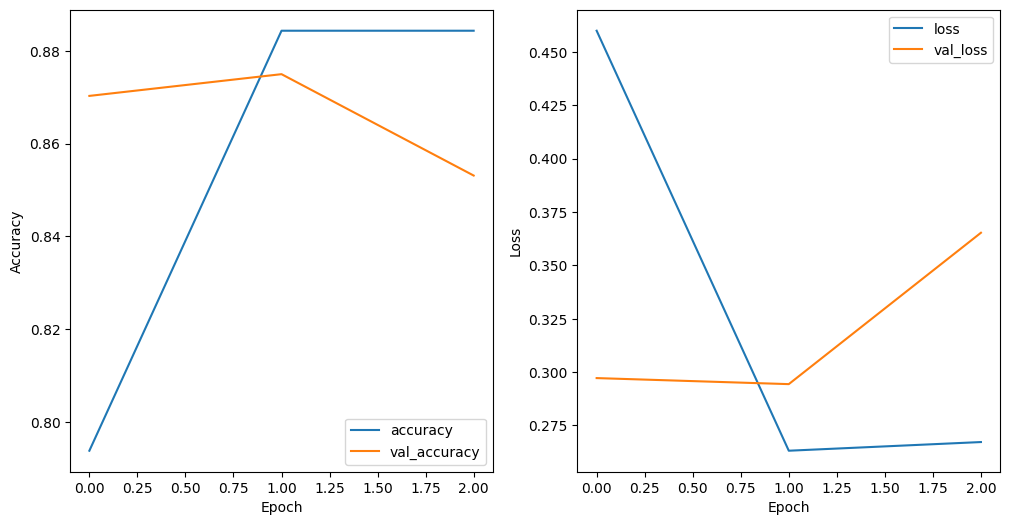

In [12]:
plt.figure(figsize=(12, 6))

# Plot de precisão
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot de perda
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

## 5. Testing the Model with an Individual Image:

In this section, we test the model by predicting the class of a single image from the validation set.

Key steps:
1. A batch of images and their corresponding labels is extracted from the validation generator using `next(val_generator)`.
    * The first image and its label are selected for testing.

2. Visualization:
    * The image is displayed using `plt.imshow` for visual analysis.

3. Preparing for Prediction:
    * An extra dimension is added to the image using `np.expand_dims` to make it compatible with the model input.

4. Prediction:
    * The model predicts the probability of the image belonging to class 1 (dog).
    * Based on the probability, the image is classified as either dog or cat.

5. Interpretation:
    * The true label (from the generator) is compared with the predicted label.

This step demonstrates the practical application of the model in classifying new images.

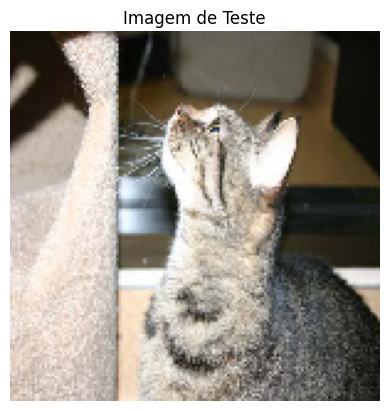

In [30]:
# Testando o modelo com uma imagem do conjunto de validação
# Extraindo uma imagem do gerador de validação
imagem, etiqueta_real = next(val_generator)  # Obtém um lote de imagens e rótulos
imagem = imagem[0]  # Seleciona a primeira imagem do lote
etiqueta_real = etiqueta_real[0]  # Seleciona o rótulo correspondente

# Plotando a imagem
plt.imshow(imagem)
plt.axis('off')
plt.title("Imagem de Teste")
plt.show()


In [31]:
# Preparando a imagem para a previsão
imagem_input = np.expand_dims(imagem, axis=0)  # Adiciona a dimensão do lote

# Fazendo a previsão
predicao = model.predict(imagem_input)  # Faz a previsão

# Interpretando a previsão
etiqueta_pred = 1 if predicao[0] > 0.5 else 0

# Exibindo resultados ajustados
print(f"Etiqueta real: {'Cachorro' if etiqueta_real == 1 else 'Gato'}")
print(f"Etiqueta prevista: {'Cachorro' if etiqueta_pred == 1 else 'Gato'}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
Etiqueta real: Gato
Etiqueta prevista: Gato
